In [2]:
import tensorflow as tf
import transformers
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import os
sys.path.append('..')
import utils
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Version Info
print("Tensforflow Version : " ,tf.__version__)
print("Transformers Version : " ,transformers.__version__)

Tensforflow Version :  2.15.0
Transformers Version :  4.38.2


In [4]:
# make a data folder
!mkdir -p data

# download the data
out_path = tf.keras.utils.get_file(origin="https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip",extract=True,cache_dir="data")
print("\n",out_path)

   8192/Unknown - 0s 0us/step
 data/datasets/sentiment+labelled+sentences.zip


In [6]:
# Read the CSV file into a DataFrame
df = pd.read_csv('sample_data/train.csv')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)  # Shuffle with fixed seed for reproducibility

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv('sample_data/train_data.csv', index=False)
validation_df.to_csv('sample_data/validation_data.csv', index=False)

train_dataset = df = pd.read_csv('sample_data/train_data.csv')
validation_dataset = df = pd.read_csv('sample_data/validation_data.csv')
test_dataset = df = pd.read_csv('sample_data/test_data.csv')

train_dataset.head()


,premise,hypothesis,label
0,a dog chases a red ball.,A cute dog paly with a ball.,0
1,A carefully dressed you boy is nonverbally com...,A young boy dressed in a potato sack is trying...,2
2,A black and white dog jumps in the snow.,The dogs are leaping into the snow.,0
3,A man singing and playing guitar on a busy sid...,A man is performing on a city sidewalk,0
4,A man holding a rifle next to his brown dog.,A man is climbing a tree.,2


In [7]:
train_dataset.shape

(494424, 3)

In [8]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [9]:
validation_dataset.shape


(54937, 3)

In [10]:
test_dataset.head()


,premise,hypothesis
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,This church choir sings to the masses as they ...,The church is filled with song.
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


In [11]:
test_dataset.shape

(9824, 2)

In [12]:
# define a max length constant
MAX_LENGTH = 64

In [13]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
print(tokenizer)
print(bert)

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position

In [15]:

train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

train_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [16]:
X_train = train_dataset['premise'] + train_dataset['hypothesis']
X_Val = validation_dataset['premise'] + validation_dataset['hypothesis']
X_test = test_dataset['premise'] + test_dataset['hypothesis']

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
# define a batch size for our experiments
BATCH_SIZE = 64
# define a percentage of the data to use for training

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset, train_dataset["label"], test_size=0.2, random_state=42)

train_ids = X_train.index.tolist()
test_ids = X_test.index.tolist()

print(len(train_ids))
print(len(test_ids))


395539
98885


In [20]:
train_sentences = [X_train.loc[s][0] + X_train.loc[s][1] for s in train_ids]
train_labels = [X_train.loc[l][2] for l in train_ids]

validation_sentences = [validation_dataset.loc[s][0] + validation_dataset.loc[s][1] for s in range(len(validation_dataset))]
validation_labels = [validation_dataset.loc[l][2] for l in range(len(validation_dataset))]

test_sentences = [X_test.loc[s][0] + X_test.loc[s][1] for s in test_ids]
test_labels = [X_test.loc[l][2] for l in test_ids]

print("LENGTHS // Train sentences: " + str(len(train_sentences)) + ". Train labels: " + str(len(train_labels)))
print("LENGTHS // Validation sentences: " + str(len(validation_sentences)) + ". Validation labels: " + str(len(validation_labels)))
print("LENGTHS // Test sentences: " + str(len(test_sentences)) + ". Test labels: " + str(len(test_labels)))

LENGTHS // Train sentences: 395539. Train labels: 395539
LENGTHS // Validation sentences: 54937. Validation labels: 54937
LENGTHS // Test sentences: 98885. Test labels: 98885


In [21]:
# Convert to one-hot encoded format
num_classes = len(set(train_labels))  # Calculate the number of classes

train_labels = to_categorical(train_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

print("train label shape:", train_labels.shape)
print("val label shape:", validation_labels.shape)

steps_per_epoch = len(train_labels) // BATCH_SIZE
validation_steps = len(validation_labels) // BATCH_SIZE


train label shape: (395539, 3)
val label shape: (54937, 3)


In [22]:
# #Implementing KMeans clustering for better labels
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Use a tfidf vectorizer
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(train_sentences)

# # Choosing 3 clusters
# k = 3

# # Apply K-means clustering
# kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)

# # Get cluster assignments for the training data
# train_cluster_labels = kmeans.labels_
# train_labels = to_categorical(train_cluster_labels, num_classes=num_classes)

In [23]:
# data generator for the model
def data_generator(sentences: np.array,labels: np.array,batch_size: int) -> (dict,tf.Tensor):
    i = 0
    start_idx = -1 * batch_size
    end_idx = 0

    while True:
        start_idx += batch_size
        end_idx += batch_size
        # TODO: append batch_size number of sentences and labels to batch_x and batch_y
        # Make sure that you don't re-use sentences and labels that you've already put into batches!

        if end_idx > len(sentences):
            end_idx = batch_size
            start_idx = 0

        batch_y = labels[start_idx:end_idx]

        # TODO: tokenize the batch_x, padding to MAX_LENGTH, and truncating to MAX_LENGTH
        batch_x = tokenizer(sentences[start_idx:end_idx], return_tensors="tf", max_length=MAX_LENGTH, truncation="longest_first", padding="max_length")

        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size, MAX_LENGTH)
        # print(batch_x['input_ids'].shape)

        # convert our ys into the appropriate tensor
        batch_y = tf.convert_to_tensor(batch_y)

        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size,)
        # print(batch_y.shape)
        yield dict(batch_x), batch_y

train_data = data_generator(train_sentences,train_labels,BATCH_SIZE)
val_data = data_generator(validation_sentences,validation_labels,BATCH_SIZE)
test_data = data_generator(test_sentences, test_labels, BATCH_SIZE)

In [24]:
# TODO: Take a look at the contents of tmp_batch_x and tmp_batch_y and report the shapes of the `input_ids`
# and the y label tensor.
# make sure that the shapes are what you expect them to be
# (take a look at the comments in the data_generator code)

tmp_batch_x,tmp_batch_y = next(train_data)
val_batch_x, val_batch_y = next(val_data)

print(tmp_batch_x["input_ids"].shape)
print(tmp_batch_y.shape)
#print(tmp_batch_y)

print(val_batch_x["input_ids"].shape)
print(val_batch_y.shape)


(64, 64)
(64, 3)
(64, 64)
(64, 3)


In [25]:
from keras.src.callbacks import History
from transformers import TFDistilBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define custom metrics functions
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    return f1


In [26]:
strategy = tf.distribute.MirroredStrategy()

In [27]:
#Get the number of GPUs needed
print("Total GPUs: ", strategy.num_replicas_in_sync)

Total GPUs:  1


In [28]:
#Prints the GPUs on your machine (if it's nvidia)
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [29]:
#This will be our steps per epoch
print(len(train_sentences)//BATCH_SIZE)

6180


In [54]:
import keras
class CustomLayer(keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        return self.bert_model(inputs)

    def get_config(self):
        config = super().get_config()
        # Add any necessary parameters to the config dictionary here if needed
        return config

with strategy.scope() as scope:

    bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased',output_attentions = False,return_dict=False)
    # we do not need attention outputs
    # we want to return tuples since they are easier to access

    bert_model.trainable = False
    # setting trainable to false ensures
    # we do not update its weights

    # Define the learning rate schedule parameters
    initial_learning_rate = 0.001
    decay_rate = 0.95
    decay_steps = 1000

    # Create an exponential decay learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True  # Optional: Whether to apply decay in a staircase manner
    )

    optimizer = Adam(learning_rate=0.0001)

    model_ = tf.keras.Sequential([
        CustomLayer(bert_model),
        tf.keras.layers.Lambda(lambda x: x[0][:,0,:]), # https://keras.io/api/layers/core_layers/lambda/
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dense(3,activation="softmax") # we have 3 classes
    ])

    # Define a checkpoint callback to save the best model
    checkpoint = ModelCheckpoint('distilbert_trained_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    model_.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1])

    # Use the first batch of training data we got to instantiate -- needed for loading weights
    model_(tmp_batch_x)

    #Load model if needed
    model_.load_weights('distilbert_trained_model.h5')
    # Define a callback to collect metrics history
    history = History()

    model_.fit(
        train_data,
        epochs=3,
        batch_size=BATCH_SIZE,
        steps_per_epoch=BATCH_SIZE*2,
        validation_data=val_data,
        validation_steps=BATCH_SIZE,
        validation_batch_size=BATCH_SIZE,
        callbacks=[history, checkpoint]
    )


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 498, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 646, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 646, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 665, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/__init__.py", line 224, in get
        raise ValueError(f"Could not interpret metric identifier: {identifier}")

    ValueError: Could not interpret metric identifier: [0.1595052  0.15234375 0.32513022]


In [45]:
#save our weights -- CANNOT SAVE MODEL BECAUSE OF LAMBDA LAYER
model_.save_weights('transformer_weights.h5')

In [46]:
# Evaluate model on test data
loss, accuracy, precision, recall, f1 = model_.evaluate(test_data, steps=BATCH_SIZE)

# Print the accuracy and loss
print('Test accuracy:', accuracy)
print('Test loss:', loss)

64/64 [==============================] - 438s 7s/step - loss: 1.0664 - accuracy: 0.4390 - precision: 0.2005 - recall: 0.0049 - f1: 0.0095
Test accuracy: 0.43896484375
Test loss: 1.0663673877716064


In [47]:
# Access the metrics history
print(history.history.keys())  # To see what metrics are available

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])


In [48]:
import numpy as np

# Access the metrics history
epochs = list(range(1, len(history.history['accuracy']) + 1))  # Assuming all metrics have the same length
precision = np.array(history.history['precision'])
recall = np.array(history.history['recall'])
f1 = np.array(history.history['f1'])
accuracy = np.array(history.history['accuracy'])
loss = np.array(history.history['loss'])
val_accuracy = np.array(history.history['val_accuracy'])
val_loss = np.array(history.history['val_loss'])


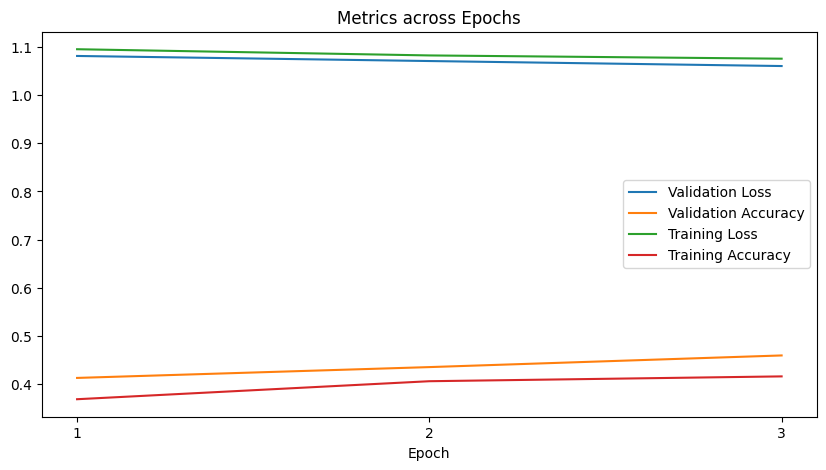

In [49]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("Transformer_BERT_training_val_loss_acc(1).pdf")  # Save the plot before showing
plt.show()


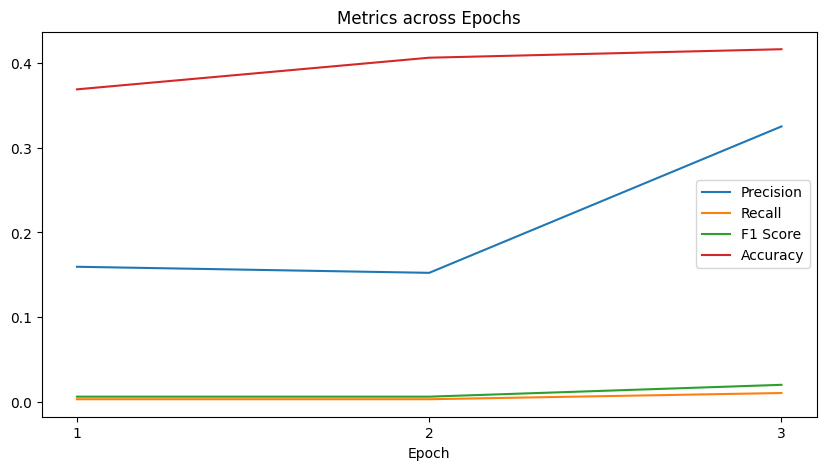

In [50]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.plot(epochs, accuracy, label='Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("Transformer_BERT_training_PRFA(1).pdf")
plt.show()